In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy.spatial import Delaunay

Define a workspace in terms of four corners, and introduce some obstacles represented as polygons.  Then plot the world, including a handy utility for plotting closed polygons.

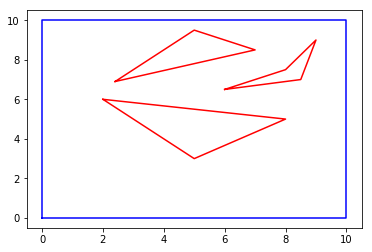

In [2]:
outer_points = np.array([[0.,0.],[0.,10.],[10.,10.],[10.0,0.0]])
obstacles = [np.array([[2.,6.],[8.,5.],[5.,3.]]),np.array([[6.,6.5],[8.5,7.],[9.,9.],[8.,7.5]])]
obstacles.append(np.array([[2.4,6.9],[7.,8.5],[5.,9.5]]))
def plot_poly(points,fmt='b-',**kwargs):
    plt.plot(np.append(points[:,0],points[0,0]),np.append(points[:,1],points[0,1]),fmt)
plot_poly(outer_points)
for ob in obstacles:
    plot_poly(ob,'r-')
plt.show()

Take all vertices together - those of the workspace and of the obstacles - and run a Delaunay triangulation.  Plot it over our world to see if the edges line up.

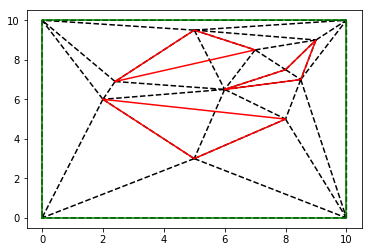

In [3]:
plot_poly(outer_points,'g-')
for ob in obstacles:
    plot_poly(ob,'r-')
all_points = outer_points
obst_edges = set([])
for ob in obstacles:
    all_points = np.append(all_points,ob[:],0)
    num_ob_points = len(ob)
    for ii in range(num_ob_points):
        new_edge = (len(all_points)-num_ob_points+ii,len(all_points)-num_ob_points+(ii+1)%num_ob_points)
        obst_edges.add((min(new_edge),max(new_edge)))
tri = Delaunay(all_points)
plt.triplot(all_points[:,0], all_points[:,1], tri.simplices.copy(),'k--')
plt.show()

They don't!  The long edge of the lower obstacle has been missed.  Identify the missing edges as those in the set of obstacle edges that are not included in the triangle edges.

In [4]:
tri_edges = set([(min(a,b),max(a,b)) for (a,b,c) in tri.simplices])
tri_edges = tri_edges.union(set([(min(a,c),max(a,c)) for (a,b,c) in tri.simplices]))
tri_edges = tri_edges.union(set([(min(c,b),max(c,b)) for (a,b,c) in tri.simplices]))
missed_edges = obst_edges-tri_edges
print(missed_edges)

{(4, 5), (11, 12)}


To correct the problem, take each missed edge and split it in two, adding the mid point to the set of all points and including the two new edges created in the set of obstacle edges.

In [5]:
for prob_edge in missed_edges:
    obst_edges.discard(prob_edge)
    new_point = 0.5*all_points[min(prob_edge)]+0.5*all_points[max(prob_edge)]
    all_points=np.append(all_points,[new_point],0)
    obst_edges.add((min(prob_edge),len(all_points)-1))
    obst_edges.add((max(prob_edge),len(all_points)-1))
    
print(obst_edges)
print(all_points)

{(12, 15), (4, 6), (5, 6), (12, 13), (4, 14), (8, 9), (9, 10), (5, 14), (7, 10), (11, 15), (7, 8), (11, 13)}
[[ 0.   0. ]
 [ 0.  10. ]
 [10.  10. ]
 [10.   0. ]
 [ 2.   6. ]
 [ 8.   5. ]
 [ 5.   3. ]
 [ 6.   6.5]
 [ 8.5  7. ]
 [ 9.   9. ]
 [ 8.   7.5]
 [ 2.4  6.9]
 [ 7.   8.5]
 [ 5.   9.5]
 [ 5.   5.5]
 [ 4.7  7.7]]


Now repeat the triangulation

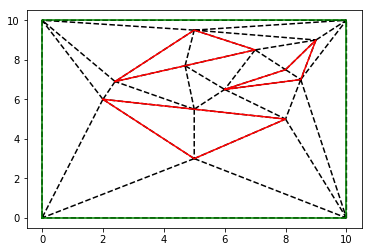

In [6]:
plot_poly(outer_points,'g-')
for ob in obstacles:
    plot_poly(ob,'r-')

tri = Delaunay(all_points)
plt.triplot(all_points[:,0], all_points[:,1], tri.simplices.copy(),'k--')
plt.show()

Now repeat the edge test and verify that all obstacle edges are in the triangle edges set.

> For proper algorithm, would need to repeat adding midpoints until all edges were captured.

In [7]:
tri_edges = set([(min(a,b),max(a,b)) for (a,b,c) in tri.simplices])
tri_edges = tri_edges.union(set([(min(a,c),max(a,c)) for (a,b,c) in tri.simplices]))
tri_edges = tri_edges.union(set([(min(c,b),max(c,b)) for (a,b,c) in tri.simplices]))
assert(obst_edges.issubset(tri_edges))
print('Got this far, so must have caught all edges OK now')

Got this far, so must have caught all edges OK now


Now to build the roadmap.  The triangulation tells us help neighbour information about each triangle.  We will include an 'entry/exit' point for each pair of neighbouring triangles if their shared edge isn't an obstacle edge.  We'll also build a distance matrix as we go, capturing the distance between entry/exit points across their common triangle. 

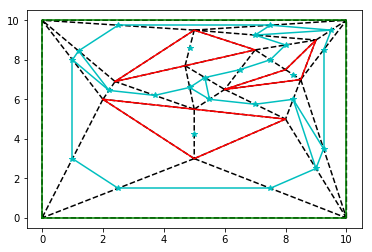

In [8]:
num_tris = len(tri.simplices)

nx_points = []
d = np.inf+np.zeros((num_tris,num_tris))
tri_nx = [[] for t in tri.simplices]
new_nx_idx = 0

for ii in range(num_tris):
    for jj in tri.neighbors[ii]:
        if jj>ii:
            common_edge = set(tri.simplices[ii]).intersection(set(tri.simplices[jj]))
            # ignore neighbour if the common edge is an obstacle edge
            if (min(common_edge),max(common_edge)) in obst_edges:
                pass
            else:
                mid_point = sum(all_points[list(common_edge)])/2.0
                #print(mid_point)
                plt.plot(mid_point[0],mid_point[1],'c*')
                nx_points.append(mid_point)
                new_nx_idx = len(nx_points)-1
                tri_nx[ii].append(new_nx_idx)
                tri_nx[jj].append(new_nx_idx)
                for nx in tri_nx[ii]:
                    d[new_nx_idx,nx] = np.linalg.norm(nx_points[nx]-nx_points[new_nx_idx])
                    d[nx,new_nx_idx] = np.linalg.norm(nx_points[nx]-nx_points[new_nx_idx])
                    plt.plot([nx_points[nx][0],nx_points[new_nx_idx][0]],[nx_points[nx][1],nx_points[new_nx_idx][1]],'c-')
                for nx in tri_nx[jj]:
                    d[new_nx_idx,nx] = np.linalg.norm(nx_points[nx]-nx_points[new_nx_idx])
                    d[nx,new_nx_idx] = np.linalg.norm(nx_points[nx]-nx_points[new_nx_idx])
                    plt.plot([nx_points[nx][0],nx_points[new_nx_idx][0]],[nx_points[nx][1],nx_points[new_nx_idx][1]],'c-')

num_nx_points = len(nx_points)
d = d[0:num_nx_points,0:num_nx_points]
                    
plot_poly(outer_points,'g-')
for ob in obstacles:
    plot_poly(ob,'r-')
plt.triplot(all_points[:,0], all_points[:,1], tri.simplices.copy(),'k--')
plt.show()

That's the roadmap done, and the distance matrix.  Next, 

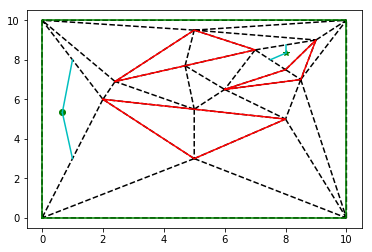

In [9]:
def append_dist_matrix(d):
    (r,c)=d.shape
    d2 = np.vstack((d,np.inf+np.zeros((1,c))))
    d3 = np.hstack((d2,np.inf+np.zeros((r+1,1))))
    return(d3)

# copy the NX points before adding start and goal to the list
nx_points_aug = nx_points[:]

# hack - select a triangle and use its midpoint as the start point
# saves identifying which triangle contains a given point
start_tri = 1
start_point = sum(all_points[tri.simplices[start_tri]])/3.

nx_points_aug.append(start_point)
d_aug = append_dist_matrix(d)
start_idx = len(nx_points_aug)-1
plt.plot(start_point[0],start_point[1],'go')
for nx in tri_nx[start_tri]:
    plt.plot([nx_points_aug[start_idx][0],nx_points_aug[nx][0]],[nx_points_aug[start_idx][1],nx_points_aug[nx][1]],'c-')
    d_aug[start_idx,nx]=np.linalg.norm(nx_points_aug[start_idx]-nx_points_aug[nx])
    d_aug[nx,start_idx]=d_aug[start_idx,nx]

#same hack for goal
goal_tri = num_tris-1
goal_point = sum(all_points[tri.simplices[goal_tri]])/3.
nx_points_aug.append(goal_point)
d_aug = append_dist_matrix(d_aug)
goal_idx = len(nx_points_aug)-1
plt.plot(goal_point[0],goal_point[1],'g*')
for nx in tri_nx[goal_tri]:
    plt.plot([nx_points_aug[goal_idx][0],nx_points_aug[nx][0]],[nx_points_aug[goal_idx][1],nx_points_aug[nx][1]],'c-')
    d_aug[goal_idx,nx]=np.linalg.norm(nx_points_aug[goal_idx]-nx_points_aug[nx])
    d_aug[nx,goal_idx]=d_aug[goal_idx,nx]
    
plot_poly(outer_points,'g-')
for ob in obstacles:
    plot_poly(ob,'r-')
plt.triplot(all_points[:,0], all_points[:,1], tri.simplices.copy(),'k--')
plt.show()

Ready for the graph search on the roadmap now.

In [10]:
from scipy.sparse.csgraph import shortest_path
distance,predecessors = shortest_path(d_aug, return_predecessors=True)
print(distance)
print(predecessors)

[[ 0.          5.         12.33092052  7.33092052 14.45224086 10.87989289
          inf  9.07711725  3.04634084  8.04634084  8.96776782  6.98682849
   8.50751912  5.76924892  6.83847763         inf  2.01556444  0.70710678
   6.17232231  5.06214214  7.69301294  3.84456258  1.82514077         inf
   2.72652859 10.01833977  2.24180744]
 [ 5.          0.          7.33092052  2.33092052  9.45224086 14.45224086
          inf 14.07230688  8.04634084 13.04634084 10.49285162  5.59523624
   4.07454561  6.81281581  1.83847763         inf  7.01556444  5.70710678
   7.69740611  7.51992259  9.21809674  8.73750215  6.82514077         inf
   7.72652859  5.01833977  7.24180744]
 [12.33092052  7.33092052  0.          5.          2.12132034  7.12132034
          inf  8.92409598 14.95487239  9.95487239 12.50355125  8.48092021
   6.96022958  9.69849978  5.49244289         inf 14.34648496 13.0380273
  10.58309008 10.40560656 12.10378071 11.62318612 13.64260793         inf
  12.74122011  2.3570226  13.342145

Finally, reconstruct the path by traversing from `start_idx` to `goal_idx`.

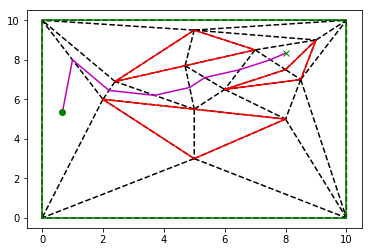

In [11]:
curr_node = start_idx
for kk in range(len(nx_points)):
    next_node = predecessors[goal_idx,curr_node]
    plt.plot([nx_points_aug[curr_node][0],nx_points_aug[next_node][0]],[nx_points_aug[curr_node][1],nx_points_aug[next_node][1]],'m-')
    curr_node=next_node
    if curr_node==goal_idx:
        break
        
plot_poly(outer_points,'g-')
for ob in obstacles:
    plot_poly(ob,'r-')
plt.triplot(all_points[:,0], all_points[:,1], tri.simplices.copy(),'k--')
plt.plot(start_point[0],start_point[1],'go',goal_point[0],goal_point[1],'gx')
plt.show()